In [56]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [319]:
def init_ring(n):
    """Initializes a graph in ring structure with n nodes
    
    Args: 
        n (int): number of nodes
    
    Returns:
        G (networkx.classes.graph.Graph): Graph in ring structure
    """
    G = nx.Graph()
    for i in range(n): G.add_node(i)
    for i in range(n-1): G.add_edge(i,i+1)
    G.add_edge(0,n-1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,pos=pos,with_labels=True)
    return(G)

def init_uniformDemand_matrix(G):
    """Returns a demand matrix, where each peer pair has the same demand in %
    
    Args:
        G (networkx.classes.graph.Graph): 
        
    Returns:
        D (numpy.ndarray): matrix with unformly distributed demands for all node pairs
    
    """
    nodesList = G.nodes
    uniformTraffic = round(1/(len(nodesList)*(len(nodesList)-1)),8)
    D = np.full((len(nodesList),len(nodesList)),uniformTraffic)
    for i in range(len(nodesList)):
        D[i][i] = 0
    return D

def calc_cost(G,D):
    """Returns the cost of traffic on a graph
    
    Args:
        G (networkx.classes.graph.Graph): network graph
        D (numpy.ndarray): Demand Graph
    Returns:
        cost (numpy.ndarray): cost of total traffic between nodes of G
    """
    nodesList = list(G.nodes)
    allShortestPath = nx.shortest_path(G)
    allShortestPathCost = [(len(allShortestPath[i][j])-1)*D[i][j]
                             for i in nodesList for j in nodesList if i!=j]
    return sum(allShortestPathCost)

def SP_edgeList(G,s,t):
    """
    Returns: Shortest Path as list of edge pairs
    """
    allShortestPath = nx.shortest_path(G)
    pathEdgeList = []
    for i in range(len(allShortestPath[s][t])-1):
        pathEdgeList.append((i,allShortestPath[s][t][i+1]))
    return pathEdgeList

def complete_node_pair_list(G):
    """
    Returns: list of all possible node pairings without duplication
    """
    nodePairList =[]
    nodes = G.nodes
    for i in G.nodes:
        nodePairList.append((i,i))
        for j in range(i+1,len(nodes)):
            nodePairList.append((i,j))
    return nodePairList

# Testing

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 4), (4, 5), (4, 6), (4, 7), (5, 5), (5, 6), (5, 7), (6, 6), (6, 7), (7, 7)]


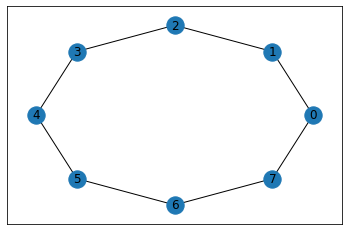

In [320]:
k = 3
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
calc_cost(G,D)
print(complete_node_pair_list(G))

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [74]:
opt_mod = gb.Model(name="linear programm")

## Setup Network Parameters

4
[0, 1, 2, 3]


/tmp/ipykernel_37210/2786941678.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


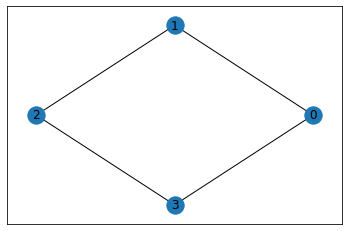

In [328]:
k = 2
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
#calc_cost(G,D)
# Setup binary adjacency matrix, i.e. unweighted
adjM = np.full((2**k,2**k),0)
A = nx.adjacency_matrix(G)
print(len(G.nodes))
allShortestPath = nx.shortest_path(G)
print(list(G.nodes))

## Setting variables

In [ ]:
maxAllowedEperNode = math.log(2**k,2) + 2
allShortestPath = nx.shortest_path(G)

edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))

# Edges/Links gb.var definition and constraints
e = gb.tupledict()
for i in G.nodes:
    for j in G.nodes:
#        if i!=j:
        e[i,j] = opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.INTEGER, lb=0, ub=1, name = "c0")
        e[j,i] = opt_mod.addVar(name=f"e_{j,i}", vtype=GRB.INTEGER, lb=0, ub=1)
    opt_mod.addConstr(e[i,((i+1) % len(G.nodes))] == 1)
    opt_mod.addConstr(sum(e[i,j] for i,j in nodesPairList.select(i, '*')) <= maxAllowedEperNode)
opt_mod.update()

# x := edges in SP
# distance :=  #x aka shortest path length
x = gb.tupledict()
distance = gb.tupledict()
for i in G.nodes:
    for j in G.nodes:
        # Distance Variable
#        if i!=j:
        distance[i,j] = opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY)
        opt_mod.addConstr(distance[i,j] >= e[i,j])
        for u in G.nodes:
            for v in G.nodes:
                x[i,j,u,v] = opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.INTEGER, lb=0, ub=1)
                #if (u != j) and (v != j) and (u != v):
                opt_mod.addConstr(x[i,j,u,v] == (1 if (u,v) in SP_edgeList(G,i,j) else 0))
                opt_mod.addConstr(x[i,j,u,v] <= e[u,v])
                #opt_mod.addConstr(distance[i,j]==sum(x[i,j]))

opt_mod.update()


opt_mod.setObjective(sum(distance[i,j]*D[i][j] for i,j in nodesPairList.select(i,j)), GRB.MINIMIZE)
opt_mod.update()
opt_mod.display()
#opt_mod.optimize()

In [323]:

# edges in shortest path
x = gb.tupledict()
distance = gb.tupledict()
for i in G.nodes:
    #cycle constraint
    
    for j in G.nodes:
        # Distance Variable
        distance[i,j] = opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY)
        opt_mod.addConstr(distance[i,j] >= e[i,j], name='c2')
        if (i,j) in e:
            for m in range(len(allShortestPath[i][j])-1):
                n = allShortestPath[i][j][m+1]
                x[i,j,m,n] = opt_mod.addVar(name=f"x_{i,j}_{m,n}", vtype=GRB.BINARY)
                opt_mod.addConstr(x[i,j,m,n] == 1, name='c1') 
                opt_mod.addConstr(x[i,j,m,n] <= e[i,j], name='c1') 
opt_mod.update()

# Constraint on shortest paths
for k in G.nodes:
    opt_mod.addConstr(distance[i,j] <= distance[i,k] + distance[k,j], name='c3')


# Total number of Edges
sumE = opt_mod.addVar(name="sumE", vtype=GRB.INTEGER, lb=0)


# blue
y = gb.tupledict()
v = 0
for i in G.nodes:
    for j in G.nodes:
        y[i,j,v] = opt_mod.addVar(name=f"y_{i,j}_{v}", vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY)
        opt_mod.addConstr(y[i,j,v] <= 1, name='c4')
        opt_mod.addConstr(0 <= y[i,j,v], name='c5')

In [ ]:
eList = e.tolist()
opt_mod.update()
for i in G.nodes:
    for j in G.nodes:
        if A[i,j]==1:
            eList[i][j] = True
        else: 
            eList[i][j] = False
opt_mod.update()
print(e)

## Setting objective function

In [187]:
opt_mod.setObjective(calc_cost(G,D), GRB.MINIMIZE)

## Setting constraints

In [71]:
# Ring
for i in list(G.nodes):
    for j in list(G.nodes):
            e[i,j] = 1
print(e)
#opt_mod.addConstr(e[i,j] = 1, name='c4')
#opt_mod.addConstr(e[len(G.nodes)-1,0] = 1, name='c5')



# distance constraints
opt_mod.addConstr(distance >= 1, name='c1')
opt_mod.addConstr(distance <= (distance[i,k]+distance[k,j]), name='c2')

#opt_mod.addConstr(0 <= y[i,j]_v <= 1, name='c3')

TypeError: 'MVar' object does not support item assignment

# Running

In [188]:
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3872 rows, 7197 columns and 5647 nonzeros
Model fingerprint: 0xa785a0d7
Variable types: 74 continuous, 7123 integer (6179 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
